# 处理数据
通常来说，当你处理图像，文本，语音或者视频数据时，你可以使用标准 python 包将数据加载成 numpy 数组格式，然后将这个数组转换成 torch.*Tensor

* 对于图像，可以用 Pillow，OpenCV

* 对于语音，可以用 scipy，librosa

* 对于文本，可以直接用 Python 或 Cython 基础数据加载模块，或者用 NLTK 和 SpaCy

特别是对于视觉，我们已经创建了一个叫做 totchvision 的包，该包含有支持加载类似Imagenet，CIFAR10，MNIST 等公共数据集的数据加载模块 torchvision.datasets 和支持加载图像数据数据转换模块 torch.utils.data.DataLoader。

### 训练一个图像分类器
我们将按次序的做如下几步：
* 使用torchvision加载并且归一化CIFAR10的训练和测试数据集
* 定义一个卷积神经网络
* 定义一个损失函数
* 在训练样本数据上训练网络
* 在测试样本数据上测试网络

加载并归一化 CIFAR10 使用 torchvision ,用它来加载 CIFAR10 数据非常简单。

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量 Tensors。

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


展示其中的一些训练图片

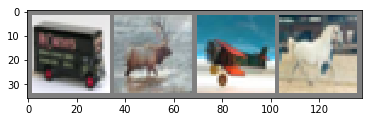

truck  deer plane horse


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, lables = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[lables[j]] for j in range(4)))

### 定义一个卷积神经网络 

在这之前先 从神经网络章节 复制神经网络，并修改它为3通道的图片(在此之前它被定义为1通道)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

定义一个损失函数和优化器 让我们使用分类交叉熵Cross-Entropy 作损失函数，动量SGD做优化器。

In [19]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

训练网络 这里事情开始变得有趣，我们只需要在数据迭代器上循环传给网络和优化器 输入就可以。

In [20]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics 
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss:%.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0

        
print('Finished Training')

[1,  2000] loss:2.223
[1,  4000] loss:1.841
[1,  6000] loss:1.683
[1,  8000] loss:1.591
[1, 10000] loss:1.524
[1, 12000] loss:1.470
[2,  2000] loss:1.390
[2,  4000] loss:1.384
[2,  6000] loss:1.359
[2,  8000] loss:1.314
[2, 10000] loss:1.319
[2, 12000] loss:1.258
Finished Training


在测试集上测试网络 我们已经通过训练数据集对网络进行了2次训练，但是我们需要检查网络是否已经学到了东西。

我们将用神经网络的输出作为预测的类标来检查网络的预测性能，用样本的真实类标来校对。如果预测是正确的，我们将样本添加到正确预测的列表里。

好的，第一步，让我们从测试集中显示一张图像来熟悉它。

In [21]:
outputs = net(images)

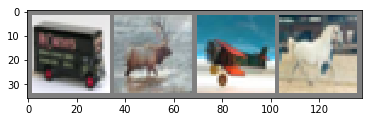

truck  deer plane horse


In [23]:
# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[lables[j]] for j in range(4)))

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  truck  deer plane horse


看看网络在整个数据集上的表现

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 67 %
Accuracy of  bird : 25 %
Accuracy of   cat : 34 %
Accuracy of  deer : 62 %
Accuracy of   dog : 57 %
Accuracy of  frog : 65 %
Accuracy of horse : 42 %
Accuracy of  ship : 74 %
Accuracy of truck : 69 %


在GPU上训练 就像你怎么把一个张量转移到GPU上一样，你要将神经网络转到GPU上。

如果CUDA可以用，让我们首先定义下我们的设备为第一个可见的cuda设备。

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


接着这些方法会递归地遍历所有模块，并将它们的参数和缓冲器转换为CUDA张量。

In [28]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

记住你也必须在每一个步骤向GPU发送输入和目标：

In [29]:
inputs, labels = inputs.to(device), labels.to(device)